


# Generate Point Prompts using ClipSeg masks

Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. But the model needs a prompt to function

There are two types of prompts accepted by SAM, either box or point prompt. Box prompt is harder to obtain and have a much higher barrier for entry. There pratically is not a way to generate these prompts unless we do it manually or use the ground truth masks (which defeats the purpose). So, we will focus on using a point prompt instead.

The current state of the art model is a finetuned version of ClipSeg, which the author claims a mIoU score of 56\%. CLIPSeg is another transformer-based segmentation model in 2021, though its influence had been eclipsed by the newer SAM and SAM2 models. We were able to reproduce this result in this [notebook](https://colab.research.google.com/drive/1gMwpge1ayXPMgeBPJqhKuWa86isoh6ya?usp=sharing) and reached a mIoU score of 56.1%.

In this notebook, we aim to lay out the method we used to generate point prompts from initial masks as evaluated by the ClipSeg model. Then, we use these point prompts to finetune our SAM2 model. (notebook link pending)

## Environment Set-up


If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True


## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from PIL import Image
from skimage.measure import label, centroid
from transformers import AutoProcessor, CLIPSegForImageSegmentation
import albumentations as A


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Implementation

In [ ]:
clipseg_processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model.load_state_dict(torch.load("/content/drive/MyDrive/CV/project/finetuned_CLIPSeg.pth", weights_only=True))
clipseg_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [ ]:
def infer_clipseg(img, model=clipseg_model, processor=clipseg_processor):
  texts = ['tumor in brain']
  new_size = (352, 352)
  model = model.to(device)

  transform = A.Resize(new_size[0], new_size[1])

  augmented = transform(image=np.array(img))
  img_transformed = augmented['image']

  inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)

  output_mask = model(**inputs, interpolate_pos_encoding=True)[0]
  binary_output_mask = torch.sigmoid(output_mask) > 0.5

  return np.squeeze(binary_output_mask.cpu().detach().float().numpy(), 0)


In [ ]:
def generate_prompt(img, demo=False):
  initial_mask = infer_clipseg(img)
  labels, num_masks = label(initial_mask, return_num=True)
  biggest = [0,0]
  for i in range(1, num_masks+1): # pick the biggest area's centroid
    area=np.sum(labels==i)
    if area>biggest[1]:
      biggest = [i, area]

  prompt_y, prompt_x = centroid(labels==biggest[0])
  width, height = img.size

  def scale(point, size): return np.round(point*size/352).astype(int)

  prompt_point = (scale(prompt_x, width) , scale(prompt_y, height)) # scale it back

  if demo:
    return prompt_point, initial_mask, (prompt_x, prompt_y)
  else:
    return prompt_point


# Testing

In [ ]:
import json

dataset_path='/content/drive/MyDrive/CV/project/archive'

file_path_valid = dataset_path+'/valid/_annotations.coco.json'
with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

categories_valid = data_valid['categories']
images_valid = data_valid['images']
annotations_valid = data_valid['annotations']

Following block was copied from clipseg notebook

In [ ]:
def create_maskGt(segmentations, input_image):
  """
  Creates a mask from a list of segmentations.

  Args:
    segmentations: A list of segmentation polygons.
    input_image: The input image.

  Returns:
    A PIL Image object representing the mask.
  """

  mask = np.zeros((input_image.height, input_image.width))
  for seg in segmentations:
    poly = np.array(seg).reshape((-1, 2))  # Chuyển đổi sang mảng numpy và định dạng lại
    img_poly = Polygon(poly)
    x, y = np.meshgrid(np.arange(input_image.width), np.arange(input_image.height))  # Tạo lưới điểm cho hình ảnh
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    path = img_poly.get_path()  # Lấy đường dẫn của đa giác
    grid = path.contains_points(points)
    grid = grid.reshape((input_image.height, input_image.width))  # Định dạng lại cho phù hợp với kích thước hình ảnh
    mask[grid] = 1  # Cập nhật mặt nạ


  return mask

In [ ]:
imgs_val = []
for index, image in enumerate(images_valid):
  if index>3:
    break
  imgs_val.append(Image.open(dataset_path+'/valid/' + image['file_name']))

msks_val = []
for i in range(len(imgs_val)):
  mask = create_maskGt(annotations_valid[i]['segmentation'],imgs_val[i])
  msks_val.append(mask)


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


(238, 332)


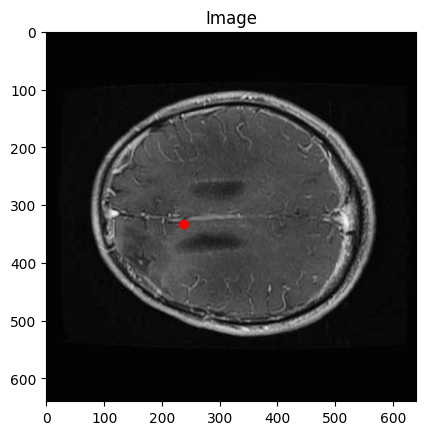

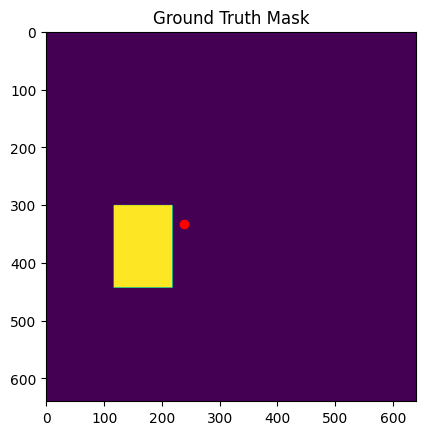

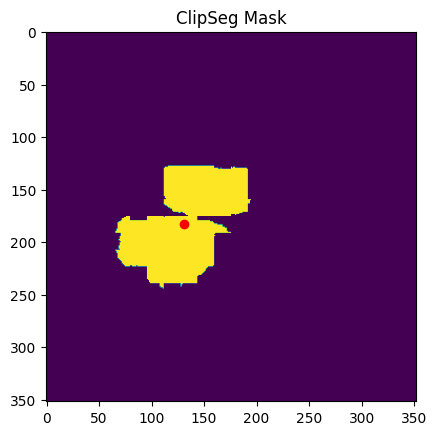

(290, 397)


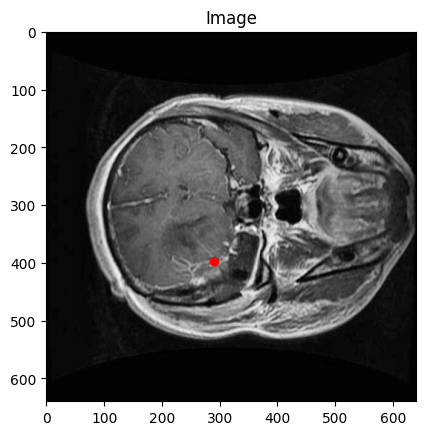

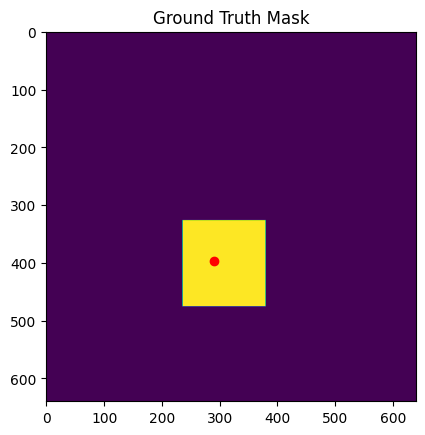

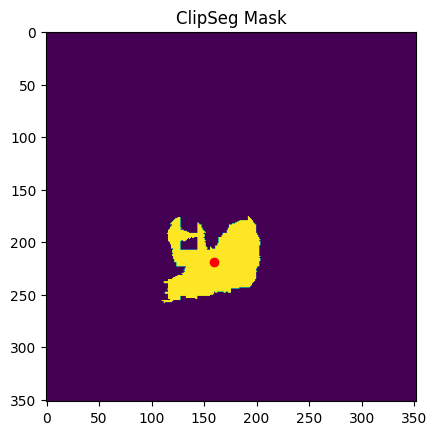

(345, 311)


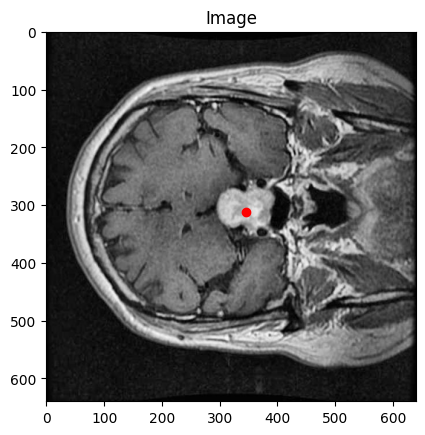

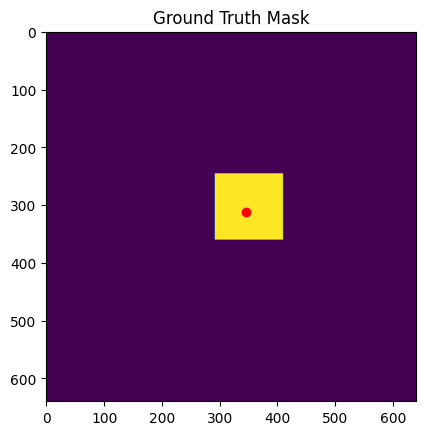

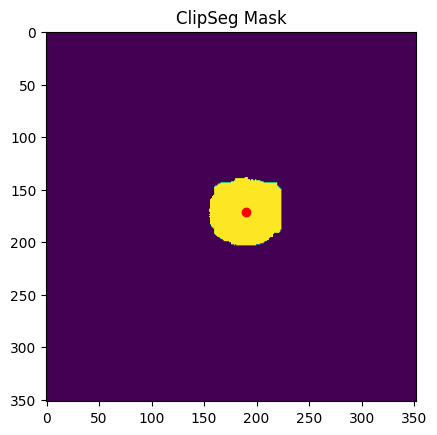

In [ ]:
for i in range(3):
  prompt_point, clipseg_mask, original_prompt_point = generate_prompt(imgs_val[i], demo=True)
  print(prompt_point)
  x,y=prompt_point

  plt.imshow(imgs_val[i])
  plt.title('Image')
  plt.plot(x, y, 'ro')
  plt.show()
  plt.imshow(msks_val[i])
  plt.title('Ground Truth Mask')
  plt.plot(x, y, 'ro')
  plt.show()

  plt.imshow(clipseg_mask)
  plt.title('ClipSeg Mask')
  plt.plot(original_prompt_point[0], original_prompt_point[1], 'ro')
  plt.show()

